In [1]:
import scanpy as sc
import anndata as ad

In [2]:
split = 3

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [4]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [6]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [7]:
adata_ood = adata_ood[adata_ood.obs["condition"]!="control"]

In [8]:
adata_pred_ood.var_names = adata_ood.var_names
adata_pred_test.var_names = adata_test.var_names

In [9]:
bdata_ood = ad.concat((adata_train, adata_ood, adata_pred_ood), label="mode", keys=["train", "ood_true", "ood_pred"])

In [10]:
sc.pp.pca(bdata_ood)
sc.pp.neighbors(bdata_ood)
sc.tl.umap(bdata_ood)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


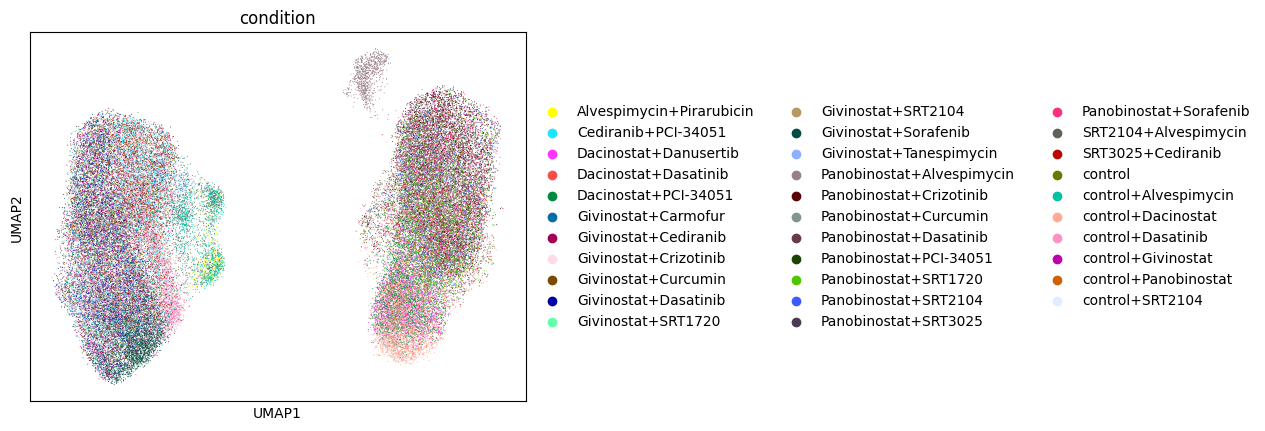

In [11]:
sc.pl.umap(bdata_ood, color=["condition"])

In [12]:
bdata_ood.obs["mode_with_control"] = bdata_ood.obs.apply(lambda x: "control" if x["condition"] == "control" else x["mode"], axis=1)

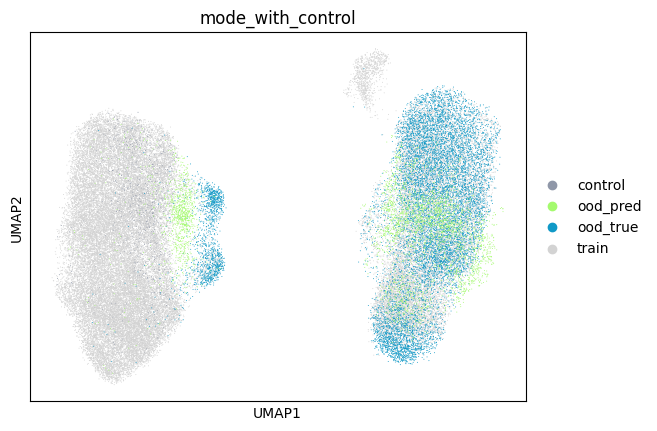

In [13]:
palette = {"control": "#8f97a8" , "ood_pred": "#a4fa6e" , "ood_true": "#1099c7" , "train": "#d3d3d3"}
sc.pl.umap(bdata_ood, color=["mode_with_control"], palette=palette)

In [14]:
def get_mode_condition(x):
    if x["mode"] == "train":
        return "train"
    return x["mode"] + "_" + x["condition"]

def get_condition_only(x, condition):
    if x["condition"] == condition:
        return x["condition"] + "_" + x["mode"]
    return "other"

In [15]:
bdata_ood.obs["mode_condition"] = bdata_ood.obs.apply(get_mode_condition, axis=1)

In [16]:
for cond in adata_ood.obs["condition"].cat.categories:
    bdata_ood.obs[cond] = bdata_ood.obs.apply(lambda x: get_condition_only(x, cond), axis=1)

In [17]:
palette = {}
for col in bdata_ood.obs[adata_ood.obs["condition"].cat.categories]:
    categories = bdata_ood.obs[col].unique()
    for cat in categories:
        if cat == "other":
            palette[cat] =  "#d3d3d3"
        elif "true" in cat:
            palette[cat] = "#1099c7"
        elif "pred" in cat:
            palette[cat] = "#a4fa6e"

In [18]:
conditions = set(adata_ood.obs["condition"].cat.categories) - set(('control',))

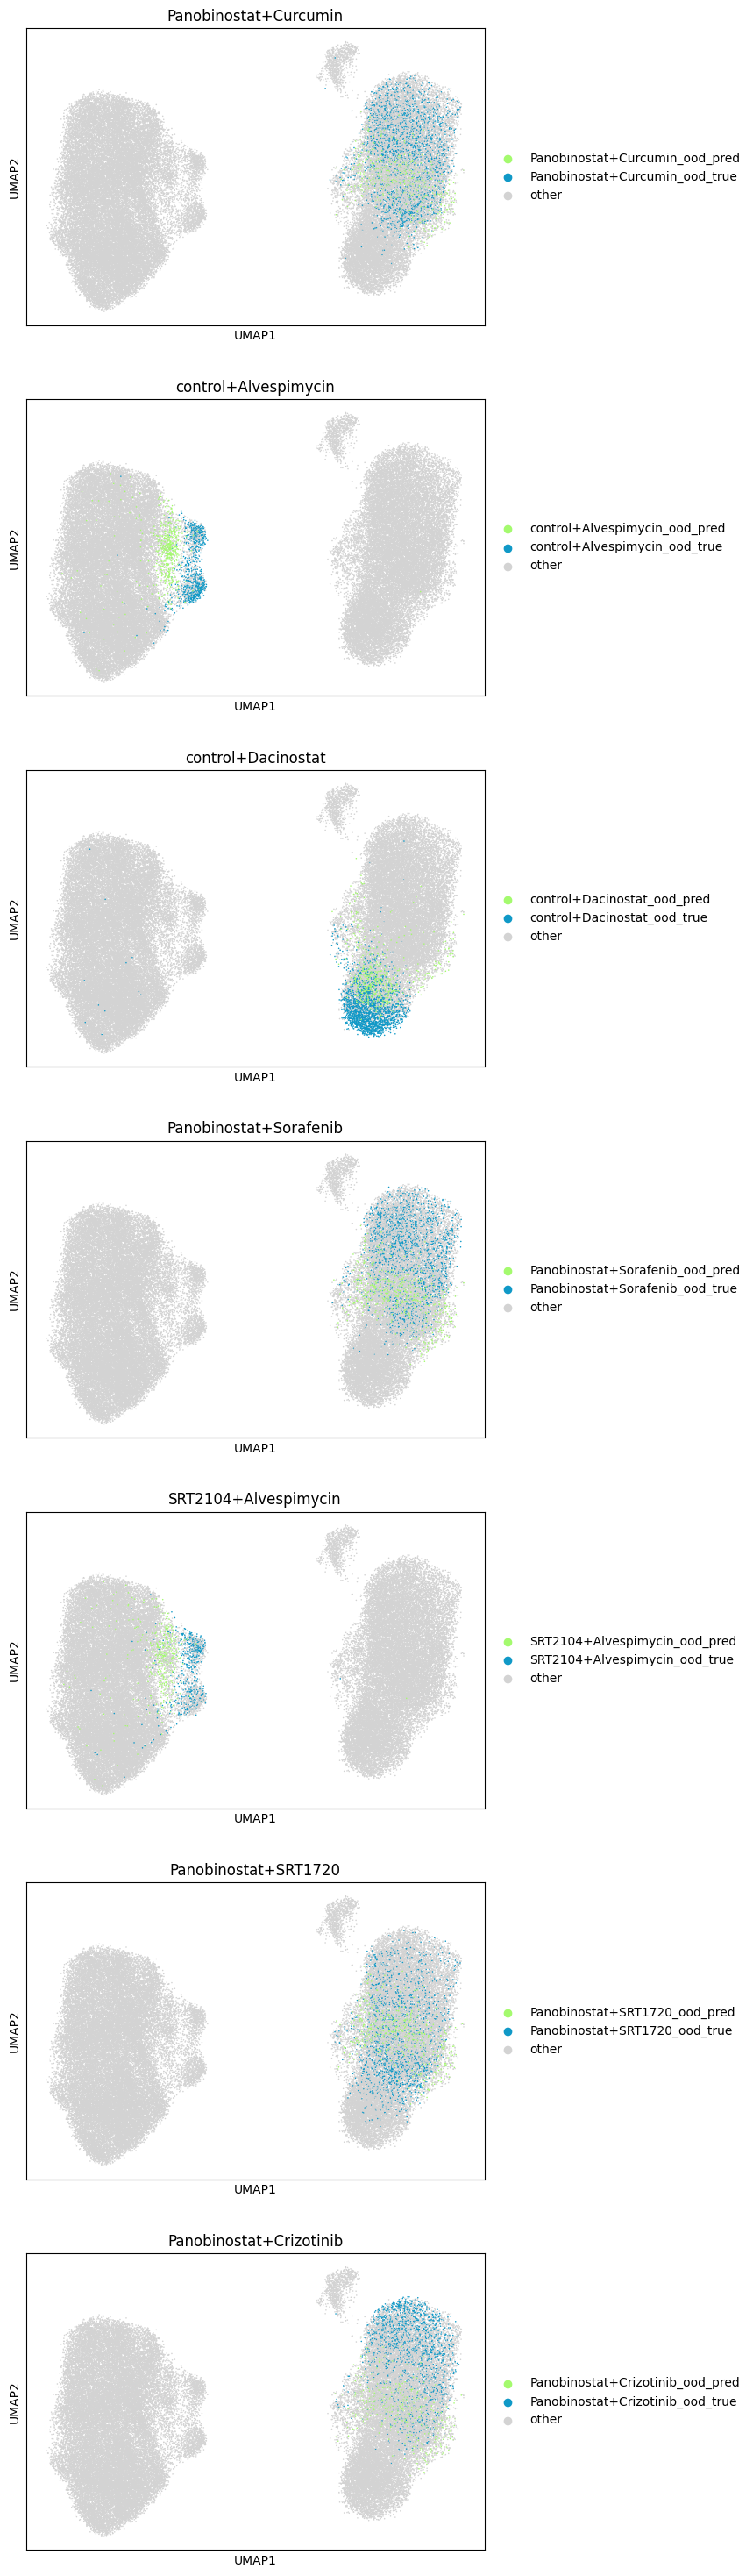

In [19]:
sc.pl.umap(bdata_ood, color=conditions, palette=palette, ncols=1, size=5)

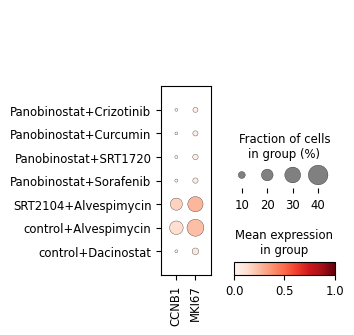

In [20]:
sc.pl.dotplot(adata_ood[adata_ood.obs["condition"]!="control"], ["CCNB1", "MKI67"], groupby="condition", vmin=0.0, vmax=1.0, expression_cutoff=0.1)


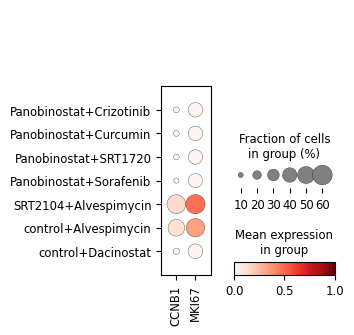

In [21]:
sc.pl.dotplot(adata_pred_ood, ["CCNB1", "MKI67"], groupby="condition", vmin=0.0, vmax=1.0, expression_cutoff=0.1)

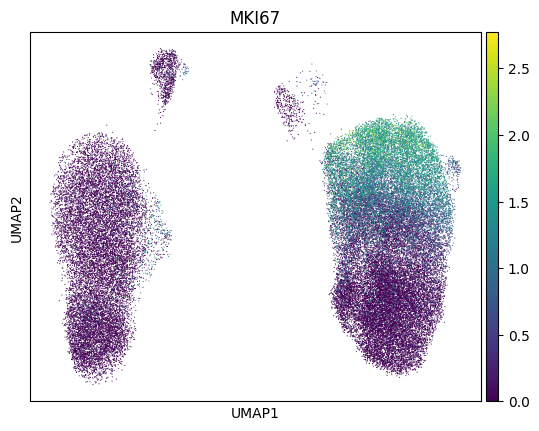

In [22]:
sc.pl.umap(adata_train, color=["MKI67"])
